# Project: Minimum-Variance Portfolio Allocation for Risky and Risk-Free Assets
In this project, students will construct a low-correlation tangent portfolio and the capital allocation line for a combination of risk-free and risky assets. 

## Learning objectives
* __Prerequisites__: begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`. We'll also compute the expected returns, covariance, and correlation arrays from this historical dataset and explore these values. 
* __Task 1__: Generate a `low-correlation` ticker collection for your tickers. In this task, you will select a collection of tickers of interest and then compute the low-correlation twins for these tickers.
    * `TODO`: Visualize the efficient frontier for risky-only assets
* __Task 2__: Compute the optimal allocation with risky and risk-free assets. Students will compute the capital allocation line to find the tangent portfolio.
    * `TOOD`: Visualize capital allocation line and the low-correlation efficient frontier

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem:

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load the historical dataset, compute the expected return and covariance
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

* Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it to the `list_of_all_tickers` array:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance and expected return for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 460` tickers), and then we'll filter out which tickers we are interested in. 

* First, we compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [13]:
all_firms_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, Δt = (1.0/252.0));

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [15]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

* Finally, we estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [17]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

* Estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ correlation matrix in the $ρ$ variable:

In [19]:
ρ = cor(all_firms_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

## Task 1: Generate a `low-correlation` ticker collection for your tickers
Let's begin by computing `low` correlation partners for each ticker in the `list_of_all_tickers` array. We begin by initializing storage for the correlation data in the `correlated_ticker_pairs::Dict{String, Array{Tuple{String, String, Float64},1}}` dictionary. We populate this dictionary using a `for-loop` over the `list_of_all_tickers.` For each ticker:
* We access the ticker at index `i` from the `list_of_all_tickers`. We then access the corresponding row in the covariance matrix `Σ` and then sort using the [Julia sortperm(...) function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm). This function returns the permutation vector that will sort the covariance entries from `smallest` to `largest.`
* Finally, we generate a list of tickers sorted by correlation in ascending order for each value of `test_ticker` using an [array comprehension operation](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) in combination with the [Julia pipe operation](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We store both the ticker and the entry of the covariance matrix:

In [21]:
correlated_ticker_pairs = Dict{String, Array{Tuple{String, String, Float64},1}}();
for i ∈ eachindex(list_of_all_tickers)
    test_ticker = list_of_all_tickers[i];
    id = sortperm(ρ[i,:])
    [(test_ticker, list_of_all_tickers[id[j]],ρ[i,id[j]]) for j ∈ eachindex(id)] |> tuple -> correlated_ticker_pairs[test_ticker] = tuple;
end

Specify a collection of tickers that interest you in the `my_list_of_tickers` array, e.g., `AAPL,` `MSFT,` etc. We'll then find the `low` correlation twin tickers, and these (along with the initial tickers) in the `my_low_correlation_ticker_array` array:

In [23]:
my_list_of_tickers = ["AAPL", "AMD", "MU", "TSLA", "GS", "WFC", "BAC"]; # you specify 5 - 10 tickers that interest you here
my_low_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ my_list_of_tickers

    correlated_list_of_tickers = correlated_ticker_pairs[base_ticker];
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_low_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = correlated_list_of_tickers[counter+1][2];
        counter += 1;
    end

    push!(my_low_correlation_ticker_array, base_ticker)
    push!(my_low_correlation_ticker_array, twin_ticker)
end
my_low_correlation_ticker_array;

## Task 2: Compute the efficient frontier for your collection of `low-correlation` assets
Create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem), and store this in the `problem_risk` variable using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. Then, we can use the `solve(...)` method for different values of the minimum desired return to compute the `efficient frontier.`

* First, let's set up the bounds and some other constants that are required for the computation of the portfolio weights along the `efficient frontier`:

In [25]:
number_of_firms = length(my_low_correlation_ticker_array);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Next, we'll get the indexes of the `low` correlation tickers that we computed above, i.e., we'll look up the position of the tickers in the `all_tickers` list and save these values in the `my_list_of_firm_ids` variable:

In [27]:
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_low_correlation_ticker_array
    firm_index = findfirst(x->x==ticker, list_of_all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Then, let's build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) type using the `build(...)` method for the `low` correlation collection of tickers, passing in the data for the required fields for the `low` correlation portfolio. Store this problem object in the `problem_risk_low_correlation` variable.
* `Note`: we use the short-cut syntax to extract the correct covariance array `Σ` and the expected return vector `μ`, i.e., we pass in the indexes for the firms we are interested in (stored in the `my_list_of_firm_ids` variable), and the correct version of the data gets returned from the short-cut methods.

In [29]:
problem_risk_low_correlation = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ(my_list_of_firm_ids), # short-cut: extracts the correct covariance,
    μ = μ(my_list_of_firm_ids), # short-cut: extracts the correct expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable. Start at the `risk-free-rate` and then look at `number_of_points` until we hit a `10`$\times$`risk-free-rate` annualized return:

In [31]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10.0*risk_free_rate, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk_low_correlation` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier_low_correlation` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier_low_correlation` dictionary.
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [33]:
efficient_frontier_low_correlation = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    try

        # update the problem object -
        problem_risk_low_correlation.R = minimum_desired_reward_array[i];
    
        # compute -
        solution = solve(problem_risk_low_correlation)

        # check: did this converge?
        status_flag = solution["status"];
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            efficient_frontier_low_correlation[key] = solution["reward"];
        end
    catch err
        # Uncomment to see which R's failed ...
        # println("Failed: desired R = $(problem_risk.R). Infeasible");
    end
end
efficient_frontier_low_correlation;

### TODO: Visualize the efficient frontier for risky-only assets
`Unhide` the code block below to see how we plotted the efficient frontier, i.e., the min-variance solution for the collection of equities.

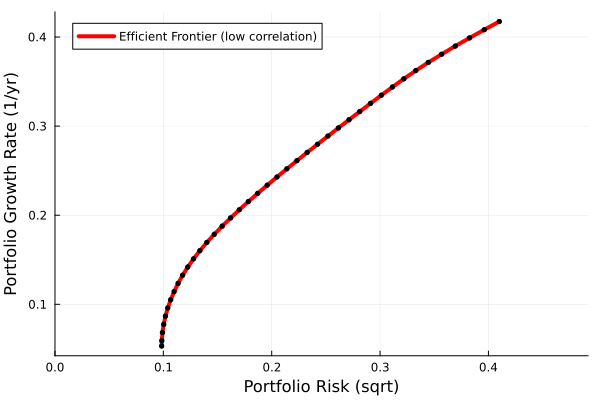

In [35]:
let
    plot(efficient_frontier_low_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
        ylabel="Portfolio Growth Rate (1/yr)", fontsize=18, label="Efficient Frontier (low correlation)", c=:red, 
        xlim=(0.0, 1.2*maximum(efficient_frontier_low_correlation).first))
    scatter!(efficient_frontier_low_correlation, label="", c=:black, ms=3)
end

## Task 2: Compute Optimal allocation with risky and risk-free assets
Let's create an instance of the [MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem), and store this in the `problem_risk_free` variable, using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}).

* Pass the covariance array estimated from data, the expected return value, bounds, an initial guess, and the risk-free rate to the `build(...)` method. Use the `short-cut syntax` to generate the covariance matrix and expected growth rate for the firms in the `my_list_of_firm_ids` list:

In [37]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ(my_list_of_firm_ids), # short-cut: extracts the correct covariance,,
    μ = μ(my_list_of_firm_ids), # short-cut: extracts the correct expected return,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level in the presence of a risk-free asset using a `for-loop.` In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward. We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [39]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    try
    
        # update the problem object -
        problem_risk_free.R = minimum_desired_reward_array[i];
        
        # compute -
        solution_risk_free = solve(problem_risk_free)
    
        # check: did this converge?
        status_flag = solution_risk_free["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution_risk_free["objective_value"]);
            value = solution_risk_free["reward"];
            capital_allocation_line[key] = value;
        end
    catch err
        # Uncomment to see which R's failed ...
        # println("Failed: desired R = $(problem_risk.R). Infeasible");
    end
end
capital_allocation_line;

### TOOD: Visualize capital allocation line
`Unhide` the code block below to see how we plotted the efficient frontier and the Capital Allocation Line (CAL) for the `low-correlation` collection of risky and risk-free assets.

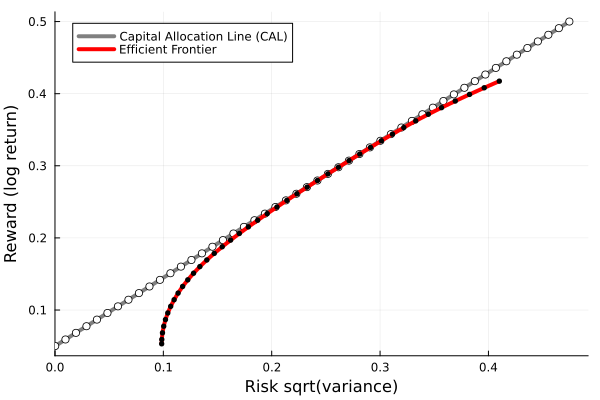

In [41]:
let
    plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Reward (annualized log growth)", fontsize=18, c=:gray, 
        xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
    scatter!(capital_allocation_line, label="", msc=:black, mc=:white)
    plot!(efficient_frontier_low_correlation, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Reward (log return)", fontsize=18, label="Efficient Frontier", c=:red, 
        xlim=(0.0, 1.2*maximum(efficient_frontier_low_correlation).first))
    scatter!(efficient_frontier_low_correlation, label="", c=:black, ms=3)
end

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.